*I worked on this assignment with Sahasra Shankar and Maheep Luthra*

# Classifying cancer expression vectors

In this assignment you will train a neural network to identify the tissue type that produced an RNA expression vector. The dataset is comprised of RNA-seq data obtained from tumors. 

For a complete description of the data collection workflow see this page:
https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net

And for the corresponding publication:
https://doi.org/10.1038/nbt.3772

In [2]:
import sys
import numpy as np
from matplotlib import pyplot
import pandas as pd
import h5py
import os
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  1.10.0+cu111


## Loading and parsing training data
For this problem, expression data needs to be loaded and pruned. Initially, there are >50,000 genes in each expression vector, which can be reduced to a much smaller gene set for the sake of minimizing computation time. Here, the data is subsetted to only include genes from the KEGG gene set. You may want to consider reducing or expanding this dataset to get a better understanding of which genes are predictive, though this is not a requirement for the assignment.

For a list of gene sets, check out the MSigDB collections page: http://software.broadinstitute.org/gsea/msigdb/collections.jsp

This script was adapted from Rob Currie's ingestion script: https://github.com/rcurrie/tumornormal/blob/master/genesets.ipynb

We have placed a subset of this data for this homework in Google drive, you can download it here:

https://drive.google.com/drive/folders/1pPABQDEHCddPTJAhfD6G5KyBDJiK3unQ?usp=sharing

In [3]:
# Load the data - If using Google drive link to access data the following with connect
# to drive, authenticate using your Google account and load the data

!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#x_test: https://drive.google.com/file/d/1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW/view?usp=sharing
#x_train: https://drive.google.com/file/d/1s8VvRaUc62OYukRunV689Y9u-v_y7KRl/view?usp=sharing
#y_test: https://drive.google.com/file/d/1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2/view?usp=sharing
#t_train: https://drive.google.com/file/d/1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD/view?usp=sharing

# 2. Now proxy the Google Drive files to a local file
x_test_import = drive.CreateFile({'id':'1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW'})
x_train_import = drive.CreateFile({'id':'1s8VvRaUc62OYukRunV689Y9u-v_y7KRl'})
y_test_import = drive.CreateFile({'id':'1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2'})
y_train_import = drive.CreateFile({'id':'1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD'})

x_test_import.GetContentFile('x_test.npz') # x_test.npz is the file name that will be accessible in the notebook.
x_train_import.GetContentFile('x_train.npz') # x_train.npz is the file name that will be accessible in the notebook.
y_test_import.GetContentFile('y_test.npz') # y_test.npz is the file name that will be accessible in the notebook.
y_train_import.GetContentFile('y_train.npz') # y_train.npz is the file name that will be accessible in the notebook.

y_index_key = {'Adipose Tissue': 0, 'Adrenal Gland': 1, 'Adrenal gland': 2, 'Bile duct': 3, 'Bladder': 4, 'Blood': 5, 'Blood Vessel': 6, 'Bone Marrow': 7, 'Brain': 8, 'Breast': 9, 'Cervix': 10, 'Cervix Uteri': 11, 'Colon': 12, 'Endometrium': 13, 'Esophagus': 14, 'Eye': 15, 'Fallopian Tube': 16, 'Head and Neck region': 17, 'Heart': 18, 'Kidney': 19, 'Lining of body cavities': 20, 'Liver': 21, 'Lung': 22, 'Lymphatic tissue': 23, 'Muscle': 24, 'Nerve': 25, 'Ovary': 26, 'Pancreas': 27, 'Paraganglia': 28, 'Pituitary': 29, 'Prostate': 30, 'Rectum': 31, 'Salivary Gland': 32, 'Skin': 33, 'Small Intestine': 34, 'Soft tissue,Bone': 35, 'Spleen': 36, 'Stomach': 37, 'SympatheticÊNervous System': 38, 'Testis': 39, 'Thymus': 40, 'Thyroid': 41, 'Thyroid Gland': 42, 'Uterus': 43, 'Vagina': 44, 'White blood cell': 45}

for name in y_index_key:
  print(name, y_index_key[name])

Adipose Tissue 0
Adrenal Gland 1
Adrenal gland 2
Bile duct 3
Bladder 4
Blood 5
Blood Vessel 6
Bone Marrow 7
Brain 8
Breast 9
Cervix 10
Cervix Uteri 11
Colon 12
Endometrium 13
Esophagus 14
Eye 15
Fallopian Tube 16
Head and Neck region 17
Heart 18
Kidney 19
Lining of body cavities 20
Liver 21
Lung 22
Lymphatic tissue 23
Muscle 24
Nerve 25
Ovary 26
Pancreas 27
Paraganglia 28
Pituitary 29
Prostate 30
Rectum 31
Salivary Gland 32
Skin 33
Small Intestine 34
Soft tissue,Bone 35
Spleen 36
Stomach 37
SympatheticÊNervous System 38
Testis 39
Thymus 40
Thyroid 41
Thyroid Gland 42
Uterus 43
Vagina 44
White blood cell 45


## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data has been stored in numpy format, which conveniently pytorch has a method for converting to their native format.

In [4]:
class PrimarySiteDataset(Dataset):
    def __init__(self, x_path, y_path, batch_size=None):
        x = np.load(x_path)['a']
        y = np.load(y_path)['a']

        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

example dataset


In [5]:
x_train_path = "x_train.npz"
y_train_path = "y_train.npz"
x_test_path = "x_test.npz"
y_test_path = "y_test.npz"
dataset_train = PrimarySiteDataset(x_path=x_train_path,y_path=y_train_path)
dataset_test = PrimarySiteDataset(x_path=x_test_path,y_path=y_test_path)

In [6]:
# Print information on the train and test datasets
print('Train datapoints: ', len(dataset_train))
print('Test datapoints: ', len(dataset_test))
print('Input features: ', len(dataset_train[1][0]))
print('Output classes: ', len(dataset_train[1][1]))

Train datapoints:  15300
Test datapoints:  3826
Input features:  5172
Output classes:  46


**Part 1 Solutions:**
1. There are 15,300 training examples in the dataset. 
2. 25% has been set aside for testing. This is calculated by doing 3826/15,300.
3. 5172 gene samples can be used as input to classify each sample.
4. There are 46 tissue types in the data labels. 
5. Based on this information, the size of the output layer in the neural network if 46. 
6.We know which output corresponds to which tissue the the probability associated with that tissue type would be the highest. 


**Part 2 Solutions:**

1. 

In [7]:
def train_batch(model, x, y, optimizer, loss_fn):
    """ This method uses model, x, y, optimizer, and loss_fn to "train" a batch within the dataset to ouput a loss score."""
    # Run forward calculation
    y_predict = model.forward(x)

    # Part 5 code - start ###
    # convert 1-hot vectors into indicies 
    max_values, target_index = y.max(dim=1) ###
    target_index = target_index.type(torch.LongTensor) ###
    
    # Compute loss.
    # loss = loss_fn(y_predict, y) #changed was 
    loss = loss_fn(y_predict, target_index)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()

In [8]:
def train(model, loader, optimizer, loss_fn, epochs=5):
    """ This method uses model, loader, optimizer, loss_fn, and epochs to train the model to output all the losses which is a list of the loss score of each batch"""
    losses = []
    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y, 
                               optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

        print("Epoch: ", e+1)
        print("Batches: ", batch_index)

    return losses

In [9]:
def test_batch(model, x, y):
    """ This method uses model, x, and y to test the model to output the y and predicted y vector """
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict

In [10]:
def test(model, loader):
    """ This method uses model and loader to test the model and returns a list of app the y and predicted y vectors """
    y_vectors = []
    y_predict_vectors = []

    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)
    y_vector = np.concatenate(y_vectors)

    return y_vector, y_predict_vector

In [11]:
def plot_loss(losses, show=True):
    """ This method uses losses and show to plot the loss of a train session """
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)

    if show:
        pyplot.show()

    pyplot.close()

In [12]:
def run(dataset_train, dataset_test):
    """ This method uses dataset_train and dataset_test to train and test the model to determine the losses, y, and y-predict"""
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 32 
    
    data_loader_train = DataLoader(dataset=dataset_train, 
                                   batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, 
                                  batch_size=len(dataset_test), shuffle=False)
    
    # Define the hyperparameters
    learning_rate = 1e-3 
    shallow_model = ShallowLinear()
    
    n_epochs = 9 
    
    # Initialize the optimizer with above parameters
    optimizer = optim.SGD(shallow_model.parameters(), lr=learning_rate)

    # Define the loss function
    loss_fn = nn.CrossEntropyLoss()  # mean squared error 

    # Train and get the resulting loss per iteration
    loss = train(model=shallow_model, loader=data_loader_train, 
                 optimizer=optimizer, loss_fn=loss_fn, epochs=n_epochs)
    
    # Test and get the resulting predicted y values
    y, y_predict = test(model=shallow_model, loader=data_loader_test)

    return loss, y, y_predict


In [13]:
class ShallowLinear(nn.Module):
    """ This class creates a linear neural network """
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear, self).__init__()
        
        # Define network layer dimensions
        D_in, H1, D_out = [5172, 32, 46]    # These numbers correspond to each layer: [input, hidden_1, output] ###

        
        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x) # hidden layer
        x = torch.relu(x)       # activation function
        
        x = self.linear2(x) # output layer
        
        x = F.log_softmax(x, dim=1) # Part 5 code change
        return x


2. The google drive link is https://docs.google.com/drawings/d/1xp-y40Q1UgCX6I-s7Jq2yoJRXk95LyOg1z7KaN1aA2g/edit?usp=sharing

3. 

In [14]:
x_train_path = "x_train.npz"
y_train_path = "y_train.npz"
x_test_path = "x_test.npz"
y_test_path = "y_test.npz"
dataset_train = PrimarySiteDataset(x_path=x_train_path, y_path=y_train_path)
dataset_test = PrimarySiteDataset(x_path=x_test_path, y_path=y_test_path)

losses,y_true, y_predict = run(dataset_train=dataset_train, dataset_test=dataset_test)

# Part 3
# 1 - Loss Testing Code:
print("Losses: ", losses[0])

# 2 - Dimension Code:
print("true y vector shape:", y_true.shape)
print("y predict vector shape:", y_predict.shape)

# 5 - Argmax Shape Code:
y_argmax = np.argmax(y_true,axis = 1)
y_pred_argmax = np.argmax(y_predict, axis = 1)
print("y true argmax shape:", y_argmax.shape)
print("y predict argmax shape:", y_pred_argmax.shape)
print("first value of y true argmax:", y_argmax[0])
print("first value of y predict argmax:", y_pred_argmax[0])

# 6 - Classification Accuracy Code:
matches = 0
for i in range(len(y_argmax)):
  if y_argmax[i] == y_pred_argmax[i]:
    matches += 1
accuracy = 100*(matches/len(y_argmax))
print("Accuracy: ", accuracy,"%")

Epoch:  1
Batches:  479
Epoch:  2
Batches:  958
Epoch:  3
Batches:  1437
Epoch:  4
Batches:  1916
Epoch:  5
Batches:  2395
Epoch:  6
Batches:  2874
Epoch:  7
Batches:  3353
Epoch:  8
Batches:  3832
Epoch:  9
Batches:  4311
Losses:  4.591856002807617
true y vector shape: (3826, 46)
y predict vector shape: (3826, 46)
y true argmax shape: (3826,)
y predict argmax shape: (3826,)
first value of y true argmax: 8
first value of y predict argmax: 8
Accuracy:  92.83847360167276 %


**Part 3 Solutions:**

1. I made changes to my initialization of the learning rate so that the final loss is no longer undefined. I also improved the performance of this by editing the H1 value to be higher. Another change I implemented was increasing the number of epochs from 4 to 9. The biggest impact on the performace was a change for the loss function type, where I changed from using MSELoss() to CrossEntropyLoss(). 


2. Once edits to the code was made, the dimensions were the same which is (3826, 46). 

3. These do match the test size from part 1. 
4. The table looks like this.

In [15]:
# Table Creation Code
table_predict = y_predict[0]
table_true = y_true[0]
df = pd.DataFrame({"y_predict":table_predict, "y":table_true})
df.head()

,y_predict,y
0,-16.562044,0.0
1,-14.815594,0.0
2,-15.764274,0.0
3,-17.734779,0.0
4,-17.680441,0.0


5. The true argmax is shape is 3826 and prediction argmax is 3826. The first value of y_argmax is 8 and the y_predict_argmax is 8. The relationship between these values and those in #4 do not make sense. There is a very big difference between the the values of these two methods. I do not expect the y_predict_argmax to match the truth set, especially since it doesn't correlate with the values in #4. 

6. The percentage of matches between the predictions and known values does change, however, the accuracy has been approximately 6.98%. 

7. The histograms is shown below along with an histogram overlap. In comparison to each other they are quite similar and begin to show some inconsistencies when the y-values increase. I would expect inconsistencies between the predicted and true if the number of epochs are too low. 

Text(0, 0.5, 'Frequency')

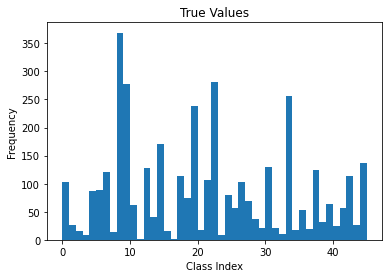

In [16]:
#histogram code for argmax values for y
pyplot.hist(y_argmax,bins = range(min(y_argmax),max(y_argmax)+1,1))
pyplot.title("True Values")
pyplot.xlabel("Class Index")
pyplot.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

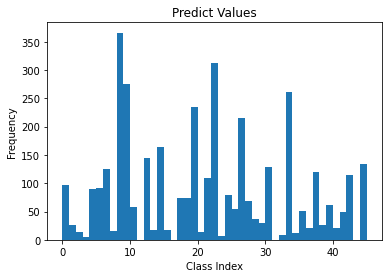

In [17]:
#histogram code for argmax values for predicted y
pyplot.hist(y_pred_argmax,bins = range(min(y_pred_argmax),max(y_pred_argmax)+1,1))
pyplot.title("Predict Values")
pyplot.xlabel("Class Index")
pyplot.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

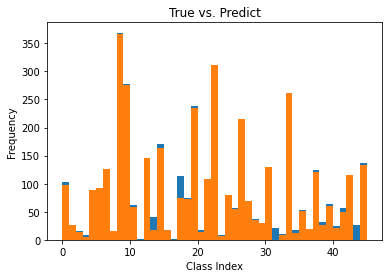

In [18]:
#histogram code for argmax values for y
pyplot.hist(y_argmax,bins = range(min(y_argmax),max(y_argmax)+1,1))
pyplot.title("True Values")
pyplot.xlabel("Class Index")
pyplot.ylabel("Frequency")

#histogram code for argmax values for predicted y
pyplot.hist(y_pred_argmax,bins = range(min(y_pred_argmax),max(y_pred_argmax)+1,1))
pyplot.title("True vs. Predict")
pyplot.xlabel("Class Index")
pyplot.ylabel("Frequency")

**Part 4 Solutions:**

I made the appropriate changes to the code.


**Part 5 Solutions:**
1. The confusion matrix creates a heat map that looks like this:

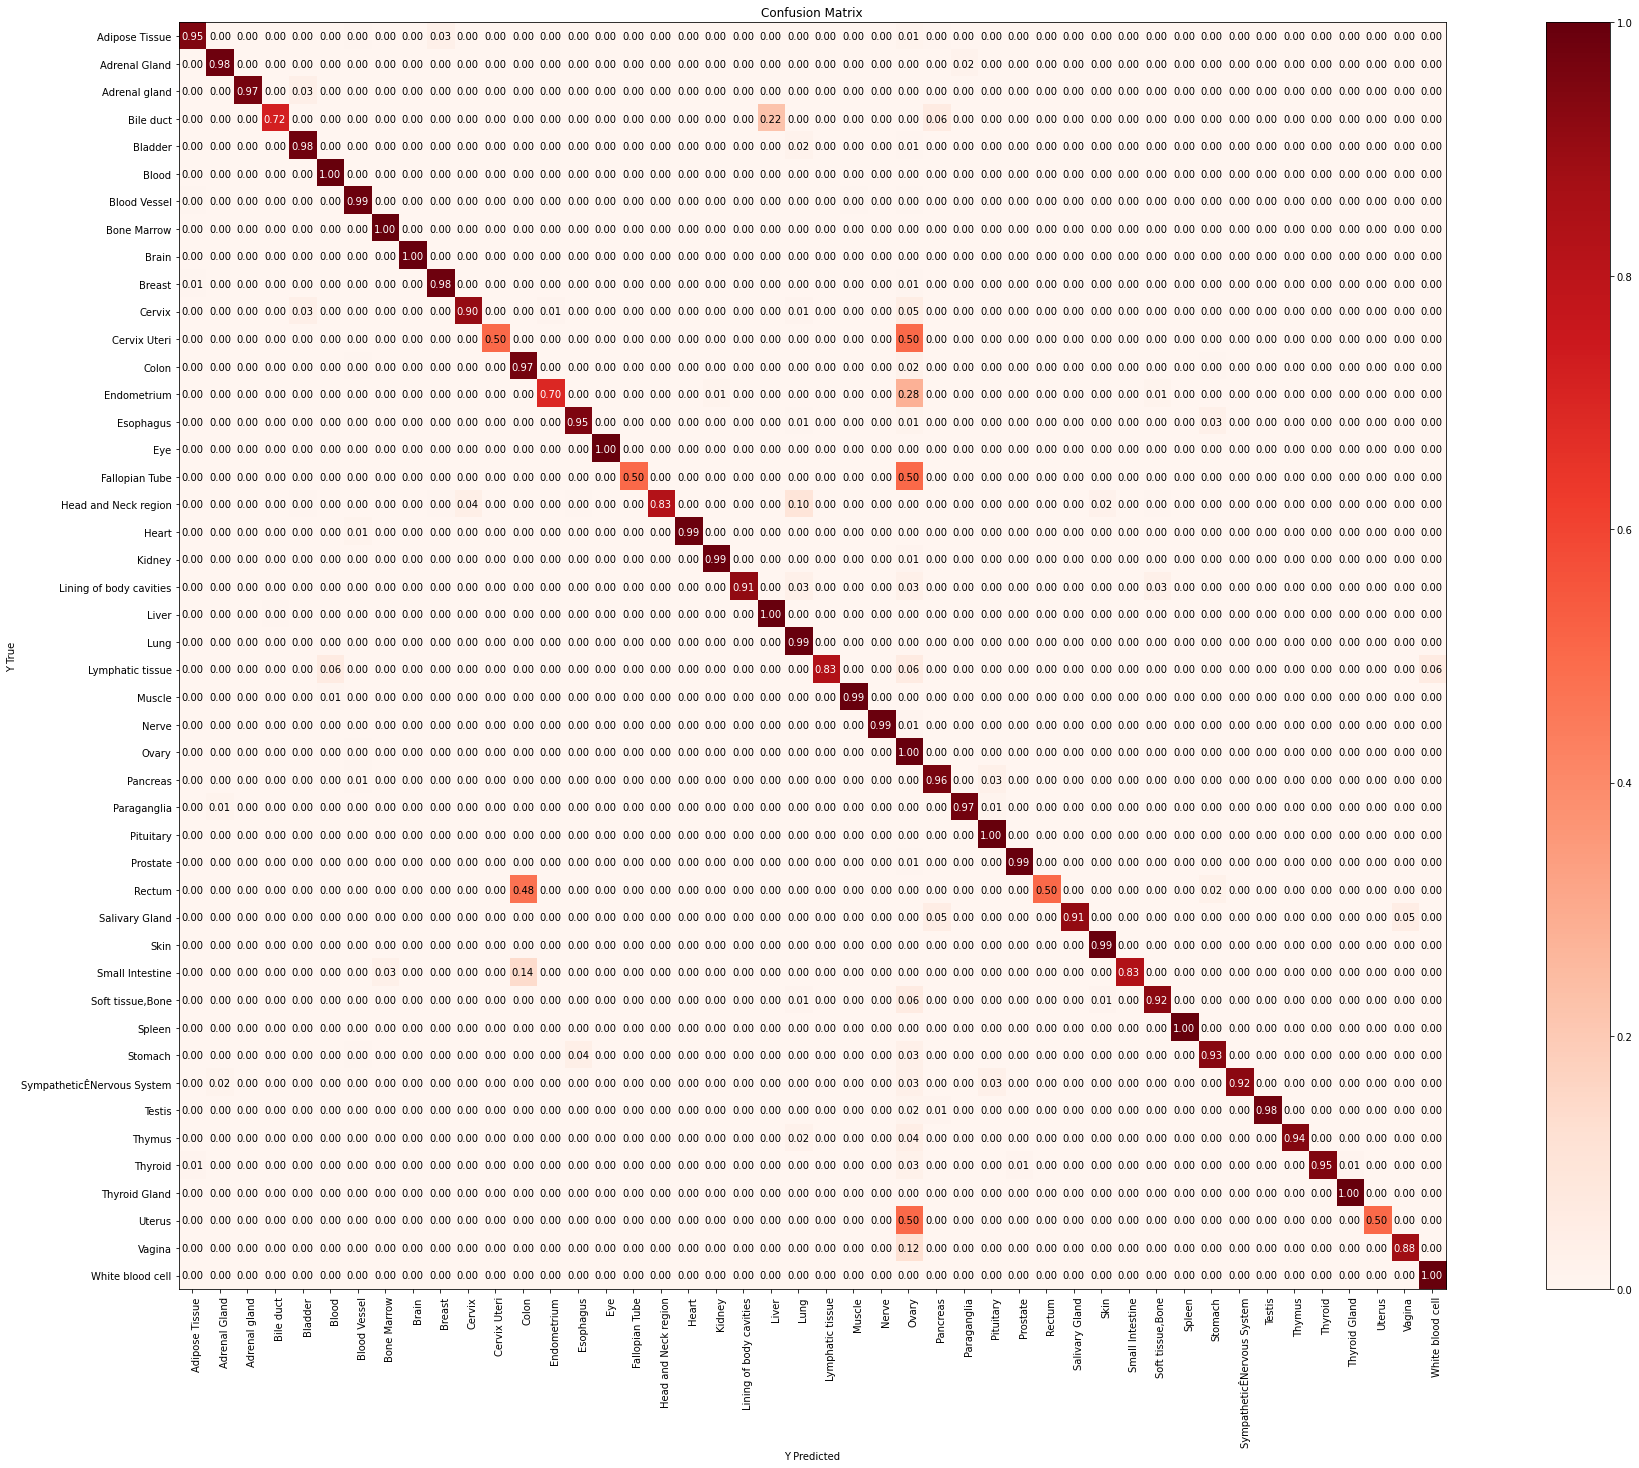

In [19]:
#confusion matrix code
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
def plot_confusion_matrix(y, y_predict, classes, title=None):
  '''y is the true values numpy array, y_predict is the predction numpy array'''

  confusionMatrix = (confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_predict, axis=1)))
  # print(confusionMatrix)


  # Creating the heat map
  # Referenced several sites to figure out how to make a heat map to name a few:
    #https://www.askpython.com/python/examples/heatmaps-in-python
    #https://www.geeksforgeeks.org/how-to-draw-2d-heatmap-using-matplotlib-in-python/
    #https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

  normalized = np.zeros(shape=[len(y_index_key.keys()), len(y_index_key.keys())], dtype=int)
  for i in range(len(y)):
    normalized[np.argmax(y[i])][np.argmax(y[i])]+=1
    normalized[np.argmax(y[i])][np.argmax(y_predict[i])]+=1
  normalized = normalized.astype('float') / normalized.sum(axis=1)[:, np.newaxis]

  # Heat map set up
  fig, plot = pyplot.subplots()
  finalPlot = plot.imshow(normalized, interpolation='nearest', cmap=pyplot.cm.Reds)
  plot.figure.colorbar(finalPlot, ax=plot)
  plot.set(xticks=np.arange(normalized.shape[1]),
         yticks=np.arange(normalized.shape[0]),
         xticklabels=classes, yticklabels=classes,
         title='Confusion Matrix',
         ylabel='Y True',
         xlabel='Y Predicted')
  pyplot.setp(plot.get_xticklabels(), rotation=90, ha="right",rotation_mode="anchor")

  # Filling heat map with data
  for i in range(normalized.shape[0]):
    for j in range(normalized.shape[1]):
      plot.text(j, i, format(normalized[i, j], '.2f'), ha="center", va="center", color="white" if normalized[i, j] > normalized.max() / 2. else "black")
  fig.set_size_inches(28.5, 20.5,forward=True)
  fig.tight_layout()
  pyplot.show()

plot_confusion_matrix(y_true, y_predict, classes = list(y_index_key.keys()), title = 'Confusion Matrix')


2. I made a few changes to the initial model such as changing the learning rate from 1e-2 to 1e-3. 
3. The final accuracy is constantly changing, but my highest accuracy has been 96.6% and usually is between the range of 89% to 96%. 

In [20]:
# Final accuracy calculation
matches = 0
for i in range(len(y_argmax)):
  if y_argmax[i] == y_pred_argmax[i]:
    matches += 1
accuracy = 100*(matches/len(y_argmax))
print("Accuracy: ", accuracy,"%")

Accuracy:  92.83847360167276 %


4. The most "confusing" tissue types for the model was the bile duct, cervix uteri, fallopian tube, rectum, small intestine, and vagina since these deviated from the expected results. Along the diagonal are where the predicted and true value agree with each other, and these specific tissue types did not agree with each other. 

In [ ]:
# Classification Report
plotLabels = list(y_index_key.keys())
print(classification_report(y_argmax, y_pred_argmax, target_names=plotLabels))

5. A lower class frequency correlates with a lower accuracy for the class. 
6. Trial and Error. I spent some time playing with the values to see which paramters had the biggest impact on the accuracy. Paramters such as the learning rate and epoch made significant impact on the accuracy. 
7. There would be 64 weight parameters and 4 bias parameters I am optimizing. Im my network, I have 32 weight parameters that I am optimizing. In comparison to my training examples in my dataset, I have fewer. 
8. Given these number, there is a a risk of overfitting, however, this can be dealt with by better regulurization which can help the model generalize to all future data. 
9. I think there can be better conbinations of hyperparameters. One such change that could be implemented is more hidden layers or hidden nodes. Changing the numbers to have a higher learning rate could also form a better model. 
10. Outside of hyperparameters, other factors that could contribute to the model's performance is the implementation of more hidden layers and nodes within the model. 
11. My model is seperating them which might indicate the lack of its ability to generalize. If I were to optimize the code, I would give it the ability to generalize. 